## Data cleaning lesson/exercise from [DataQuest](https://www.dataquest.io/m/136/data-cleaning-walkthrough)

Read CSV datasets into Pandas DataFrame objects that we'll store in a dictionary

In [1]:
import pandas as pd

# NYC high school datasets we'll use, from NYC Open Data (https://data.cityofnewyork.us/Education)
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

# create a dictionary of data file names, minus .csv extension (keys) to corresponding Pandas DataFrames (values) 
data = {}
for data_file in data_files:
    dataset_name = data_file.split(".")[0]
    data[dataset_name] = pd.read_csv(data_file)

Read survey datasets which are not CSV but instead are tab delimited text files with a "windows-1252" encoding:

In [3]:
# read the survey datasets into Pandas DataFrame objects
all_survey = pd.read_csv("survey_all.txt", 
                         delimiter="\t", 
                         encoding="windows-1252")
d75_survey = pd.read_csv("survey_d75.txt", 
                         delimiter="\t", 
                         encoding="windows-1252")

# combine the two surveys into a single DataFrame object
survey = pd.concat((all_survey, d75_survey), axis=0, sort=True)

C:\home\miniconda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  import sys


Clean the survey DataFrame by 

1. renaming the "dbn" field to "DBN", and 
2. filtering down to only the fields we'll need for our analysis

In [4]:
# copy the "dbn" column as a column named "DBN"
survey["DBN"] = survey["dbn"]

# create a list of the relevant fields we'll want to filter into our "survey" DataFrame
survey_fields = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]

# filter the DataFrame, assign it into the data dictionary
data["survey"] = survey[survey_fields]

Create a function to help with creating a DBN column for the class_size DataFrame. The function should behave as follows:

- Takes in a number.
- Converts the number to a string using the str() function.
- Pads the string with a zero if the length of the string is only 1 digit.
- Returns the string

In [7]:
def num_to_str(number):
    return str(number).zfill(2)

Create a DBN column in the class_size DataFrame from the "CSD" (padded with a leading zero if necessary) and "SCHOOL CODE" columns.

In [8]:
data["class_size"]["DBN"] = data["class_size"]["CSD"].apply(lambda x: num_to_str(x)) + data["class_size"]["SCHOOL CODE"]

Create a "DBN" column in the "hs_directory" DatFrame (copy the "dbn" column and name it "DBN").

In [10]:
data["hs_directory"].rename(columns={'dbn': 'DBN'}, inplace=True)

Create a total SAT score column from the three component SAT score columns in the `sat_results` DataFrame.

In [11]:
cols = ["SAT Math Avg. Score", 
        "SAT Critical Reading Avg. Score", 
        "SAT Writing Avg. Score"]
for col in cols:
    data["sat_results"][col] = \
        pd.to_numeric(data["sat_results"][col], errors="coerce")

data["sat_results"]["sat_score"] = \
    data["sat_results"]["SAT Math Avg. Score"] +\
    data["sat_results"]["SAT Critical Reading Avg. Score"] +\
    data["sat_results"]["SAT Writing Avg. Score"]

Use a regular expression to pull the lat/lon values from the `Location 1` column of the `hs_directory` DataFrame:

In [29]:
import re

def extract_lat(location):
    
    # get the first part of the lat/lon pair
    lat = re.findall("\(.+\)", location)[0].split()[0]
    
    # clean off the leading parenthesis and the comma
    lat = lat.replace("(", "").replace(",", "")
    
    # return the lat value as a string
    return lat
    
    
def extract_lon(location):
    
    # get the second part of the lat/lon pair
    lon = re.findall("\(.+\)", location)[0].split()[1]
    
    # clean off the trailing parenthesis and the comma
    lon = lon.replace(")", "").replace(",", "")
    
    # return the lon value as a string
    return lon
    
# create lat and lon columns from the lat/lon values extracted from the "Location 1" column
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(extract_lat) 
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(extract_lon) 

# convert the string values to numeric
data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"],
                                            errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"],
                                            errors="coerce")

# look to make sure we have what we expect
data["hs_directory"][["Location 1", "lat", "lon"]].head()

,Location 1,lat,lon
0,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...",40.670299,-73.961648
1,"1110 Boston Road\nBronx, NY 10456\n(40.8276026...",40.827603,-73.904475
2,"1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...",40.842414,-73.916162
3,"411 Pearl Street\nNew York, NY 10038\n(40.7106...",40.710679,-74.000807
4,"160 20 Goethals Avenue\nJamaica, NY 11432\n(40...",40.718810,-73.806500


## Condense the `class_size` DataFrame

First we'll filter the `class_size` DataFrame down to general education classes containing grades 9-12:

In [30]:
class_size = data["class_size"]
data["class_size"] = class_size[(class_size["GRADE "] == "09-12") & (class_size["PROGRAM TYPE"] == "GEN ED")]
data["class_size"].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,DBN
225,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN,01M292
226,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN,01M292
227,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 11,-,38.0,2.0,19.0,16.0,22.0,STARS,NaN,01M292
228,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 12,-,69.0,3.0,23.0,13.0,30.0,STARS,NaN,01M292
229,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,MATH,Integrated Algebra,-,53.0,3.0,17.7,16.0,21.0,STARS,NaN,01M292


Combine the various class sizes for non-unique `DBN` rows into unique rows for each `DBN` using an aggregation of mean values with a groupby object:

In [32]:
import numpy as np
class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size
data["class_size"].head()

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M015,1,17.727273,1.090909,16.545455,16.454545,16.636364,8.4
1,01M019,1,24.250000,1.333333,17.625000,17.333333,17.916667,10.0
2,01M020,1,43.923077,2.076923,21.976923,21.307692,22.538462,13.4
3,01M034,1,38.038462,1.692308,21.461538,20.730769,22.038462,9.6
4,01M063,1,16.400000,1.000000,16.400000,16.400000,16.400000,7.6


### Condense the `demographics` DataFrame down to the school year for which we have our SAT dataset: 

In [33]:
demographics = data["demographics"]
demographics = demographics[demographics["schoolyear"] == 20112012]
data["demographics"] = demographics
data["demographics"].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,28,...,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
13,01M019,P.S. 019 ASHER LEVY,20112012,NaN,61.5,328,32,46,52,54,...,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2
20,01M020,PS 020 ANNA SILVER,20112012,NaN,92.5,626,52,102,121,87,...,55,8.8,357,57.0,16,2.6,330.0,52.7,296.0,47.3
27,01M034,PS 034 FRANKLIN D ROOSEVELT,20112012,NaN,99.7,401,14,34,38,36,...,90,22.4,275,68.6,8,2.0,204.0,50.9,197.0,49.1
35,01M063,PS 063 WILLIAM MCKINLEY,20112012,NaN,78.9,176,18,20,30,21,...,41,23.3,110,62.5,15,8.5,97.0,55.1,79.0,44.9


### Condense the `graduation` DataFrame down to the actual/total cohort groups, in order to assign each a unique `DBN` identifier.

In [34]:
graduation = data["graduation"]
graduation = graduation[(graduation["Cohort"] == "2006") & (graduation["Demographic"] == "Total Cohort")]
data["graduation"] = graduation
data["graduation"].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53,42.7%,42,33.9%,79.2%,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
17,Total Cohort,01M450,EAST SIDE COMMUNITY SCHOOL,2006,90,70,77.8%,67,74.400000000000006%,95.7%,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%
24,Total Cohort,01M509,MARTA VALLE HIGH SCHOOL,2006,84,47,56%,40,47.6%,85.1%,...,23,27.4%,48.9%,7,8.300000000000001%,14.9%,25,29.8%,5,6%
31,Total Cohort,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHO,2006,193,105,54.4%,91,47.2%,86.7%,...,22,11.4%,21%,14,7.3%,13.3%,53,27.5%,35,18.100000000000001%


#### Since we'll be looking at AP students to see how they relate to SAT scores we'll want to have a dataset containing values related to AP tests. We'll first make sure that the relevant columns are of numeric type:

In [35]:
cols = ['AP Test Takers ', 
        'Total Exams Taken', 
        'Number of Exams with scores 3 4 or 5']

ap_2010 = data["ap_2010"]
for col in cols:
    ap_2010[col] = pd.to_numeric(ap_2010[col], errors='coerce')
data["ap_2010"] = ap_2010

## Combine the datasets using various merge types
First we'll merge the `sat_results` dataset with the `ap_2010` and `graduation` datasets using a left join on the `DBN` column:

In [36]:
combined = data["sat_results"]
combined = combined.merge(data["ap_2010"], how="left", on="DBN")
combined = combined.merge(data["graduation"], how="left", on="DBN")
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%
3,01M458,FORSYTH SATELLITE ACADEMY,7,414.0,401.0,359.0,1174.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,NaN,NaN,NaN,...,23,27.4%,48.9%,7,8.300000000000001%,14.9%,25,29.8%,5,6%


Next we'll merge the `class_size`, `demographics`, `survey`, and `hs_directory` using an inner join, since these datasets are assumed/known to have more or less matching `DBN` columns with the original `sat_results` dataset (an inner join merges only on matching `on=` column values).

combined = combined.merge(data["class_size"], how="inner", on="DBN")
combined = combined.merge(data["demographics"], how="inner", on="DBN")
combined = combined.merge(data["survey"], how="inner", on="DBN")
combined = combined.merge(data["hs_directory"], how="inner", on="DBN")
combined.head()

Now to fill in missing/NA values we'll assign the mean value of a column to all rows where the columns value is missing 

In [39]:
means = combined.mean()
combined = combined.fillna(means)
combined = combined.fillna(0)

Now we'll add a column to the data set that specifies the school district, in order to facilitate mapping out the various statistics on a school district level. The school district code is the first two letters from the `DBN` column value.

In [40]:
combined["school_dist"] = combined["DBN"].apply(lambda x: x[0:2])

## Analysis
Now we'll see if there are any interesting correlations (Pearson r-values), using `pandas.DataFrame.corr()`. First we'll examine the correlations with the `sat_score` column to see if any other columns show a strong positive or negative correlation. Onlt correlations greater than an absolute value of 0.25 are deemed interesting, i.e. only these imply an actual correlation that may be of interest.

In [43]:
correlations = combined.corr()
correlations[abs(correlations["sat_score"]) > 0.25]["sat_score"]

SAT Critical Reading Avg. Score         0.986796
SAT Math Avg. Score                     0.972676
SAT Writing Avg. Score                  0.987935
sat_score                               1.000000
AP Test Takers                          0.516145
Total Exams Taken                       0.507801
Number of Exams with scores 3 4 or 5    0.460134
Total Cohort                            0.318515
NUMBER OF STUDENTS / SEATS FILLED       0.498658
NUMBER OF SECTIONS                      0.465216
AVERAGE CLASS SIZE                      0.357590
SIZE OF LARGEST CLASS                   0.333910
SCHOOLWIDE PUPIL-TEACHER RATIO          0.444838
frl_percent                            -0.722722
total_enrollment                        0.363096
ell_percent                            -0.400259
sped_percent                           -0.446034
asian_num                               0.470601
asian_per                               0.567850
black_per                              -0.289611
hispanic_per        

There's a small correlation around total enrollment, let's visualize the two columns using a scatter plot to see if there's a trend we can notice:

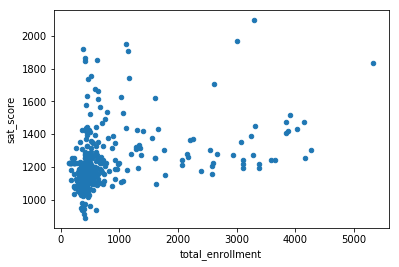

In [45]:
%matplotlib inline

combined.plot.scatter(x="total_enrollment", y="sat_score")

There's an interesting cluster of points at the bottom left where total_enrollment and sat_score are both low. This cluster may be what's making the r value so high. It's worth extracting the names of the schools in this cluster so we can research them further. We'll filter the rows where total enrollment and SAT score are both less than 1000.

In [47]:
low_enrollment = combined[(combined["total_enrollment"] < 1000) & (combined["sat_score"] < 1000)]
low_enrollment["School Name"]

93       INTERNATIONAL COMMUNITY HIGH SCHOOL
128                                        0
129          BRONX INTERNATIONAL HIGH SCHOOL
142    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
144    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
179                                        0
182            HIGH SCHOOL OF WORLD CULTURES
191       BROOKLYN INTERNATIONAL HIGH SCHOOL
228    INTERNATIONAL HIGH SCHOOL AT PROSPECT
240               IT TAKES A VILLAGE ACADEMY
256                MULTICULTURAL HIGH SCHOOL
289    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object

Based on the schools we've found it looks like there's a high percentage of English language learners in these schools, since many of these have a high percentage of immigrant students. Let's next plot the percentage of Enlish language learners against the SAT scores to see if there's a more interesting correlation.

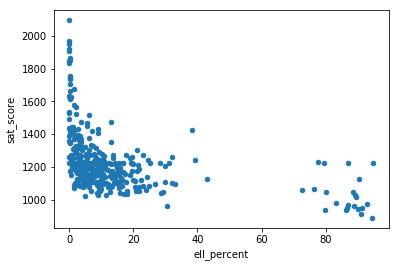

In [48]:
combined.plot.scatter(x="ell_percent", y="sat_score")

Next we'll plot all of the schools on a map of NYC, using Basemap.

C:\home\miniconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\home\miniconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


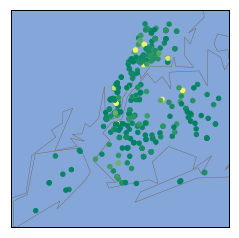

In [53]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = combined["lon"].tolist()
latitudes = combined["lat"].tolist()
m.scatter(x=longitudes, y=latitudes, s=20, zorder=2, latlon=True, c=combined["ell_percent"], cmap="summer")

The above map is tricky to make out much, let's group by district to see if there's a more intuitive visualization we can create based on that. We'll first need to group by school district, getting average values for each, and then resetting the index in order to set the school district back as a column.

In [55]:
import numpy as np
districts = combined.groupby("school_dist").agg(np.mean)
districts.reset_index(inplace=True)
districts.head()

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,priority08,priority09,priority10,Community Board,Council District,Census Tract,BIN,BBL,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.398724,172.574163,135.800000,93.500000,1.0,...,0.0,0.0,0.0,3.000000,1.500000,1106.833333,1.004144e+06,1.003302e+09,40.719022,-73.982377
1,02,429.805816,446.435312,427.544570,1303.785697,126.304211,197.225263,157.334000,155.195256,2.0,...,0.0,0.0,0.0,4.255824,2.922308,1088.887363,1.100068e+06,1.067595e+09,40.739540,-73.991099
2,03,428.678783,438.115232,427.051187,1293.845203,155.854067,244.003190,193.087500,183.193910,3.0,...,0.0,0.0,0.0,7.500000,6.500000,166.666667,1.034931e+06,1.012833e+09,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,128.693780,183.370472,151.035714,113.857143,4.0,...,0.0,0.0,0.0,11.000000,8.000000,2637.000000,1.055874e+06,1.016681e+09,40.793449,-73.943215
4,05,427.245019,438.303942,419.743535,1285.292497,85.561176,115.470950,142.464286,143.459707,5.0,...,0.0,0.0,0.0,9.428571,8.142857,9372.571429,1.063080e+06,1.019721e+09,40.817077,-73.949251


Next we can reproduce our map using the DataFrame containing district averages.

C:\home\miniconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\home\miniconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


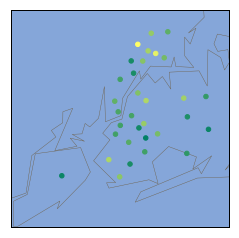

In [57]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

m.scatter(x=longitudes, y=latitudes, s=20, zorder=2, latlon=True, c=districts["ell_percent"], cmap="summer")